This is based off of this Project:

1) provides the forward model of the imaging process.  Namely given a numerical phantom (“image”) of say the head), takes user provided field maps for the B0 magnet, and the gradients and RF coil and generates what the kspace of that object is expected to be.
2) Show the conventional FFT reconstruction of this modeled data and compare it to the ground truth object with some set of metrics (of distortion etc.)
3) Do an iterative reconstruction of the ground-truth object using the forward model to give a "best case” look at how this configuration of fields would image.  Note that if the fields render an ill-posed inverse problem, there will be residual aliasing and noise amplification.  Provide metrics of these.

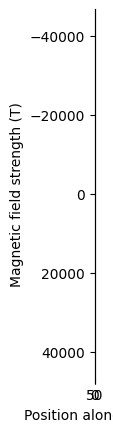

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

N_spins = 100  # Number of spins in each direction
# Create the phantom
phantom = np.ones((N_spins, N_spins), dtype=np.complex128)  # All spins start in equilibrium state
plt.imshow(np.abs(phantom))

gamma = 42.58e6  # Gyromagnetic ratio for hydrogen in Hz/T
G = 1e-3  # Gradient strength in T/m

B0 = 1  # Magnetic field strength in T
omega0 = gamma * B0  # Larmor frequency in Hz


# Calculate the magnetic field in each direction
Bx = G * omega0 * np.cos(2 * np.pi * np.arange(N_spins) / N_spins)
By = G * omega0 * np.sin(2 * np.pi * np.arange(N_spins) / N_spins)

plt.plot(Bx)
plt.xlabel('Position along x-axis')
plt.ylabel('Magnetic field strength (T)')
plt.show()

# Add the magnetic field to the spins
phantom += Bx[:, np.newaxis] * np.cos(2 * np.pi * np.arange(N_spins) / N_spins)[np.newaxis, :]
phantom += By[:, np.newaxis] * np.sin(2 * np.pi * np.arange(N_spins) / N_spins)[np.newaxis, :]
phantom *= np.exp(-1j * omega0 * 1e-3)  # Add a phase shift to the spins

# Plot the absolute value of the spins
#plt.imshow(np.abs(phantom))


